In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
import scipy.ndimage

In [8]:
'''Data was the same data that was used for the notMNIST lesson'''

labels = np.load("../data/notMNIST/train_labels.npy")
train_images = np.load("../data/notMNIST/train_images.npy")
test_images = np.load("../data/notMNIST/test_images.npy")
label_names = np.array(['A','B','C','D','E','F','G','H','I','J'])

In [9]:
print("There are "+str(train_images.shape[0]) + " images in the dataset")
print("The dimensions of each image are "+str(train_images.shape[1])+" by "+ str(train_images.shape[2]))
print(test_images.shape)

There are 100 images in the dataset
The dimensions of each image are 28 by 28
(100, 28, 28)


In [10]:
def get_image_and_label(image_number):
    plt.matshow(train_images[image_number], cmap=plt.cm.gray)
    print(label_names[labels[image_number]])

def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)

Origional image
Downscaled by 1/2
Upscaled back to origional


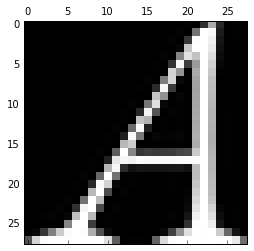

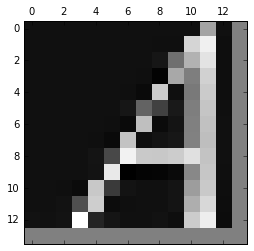

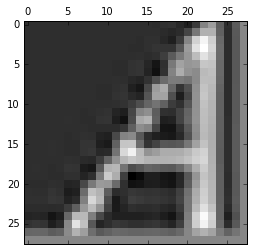

In [11]:
'''
This code shows what the effect of these scaling functions is. Tensorflow actually has image scaling built in as well. 
'''

print("Origional image")
show_image(train_images[0])
print("Downscaled by 1/2")
show_image(scipy.ndimage.zoom(train_images[0],.5))
print("Upscaled back to origional")
show_image(scipy.ndimage.zoom(scipy.ndimage.zoom(train_images[0],.5),2))


In [12]:
'''This code creates downscaled datasets that can be used for training. 

'''
downscaled_train = np.array([scipy.ndimage.zoom(i,.5) for i in train_images])
downscaled_test = np.array([scipy.ndimage.zoom(i,.5) for i in test_images])
print(downscaled_train.shape)
print(train_images.shape)

(100, 14, 14)
(100, 28, 28)


In [7]:
'''
Model 1

Uses single layer NN. No convolution. 
'''

small_train = tf.placeholder('float32', shape = [None, 14, 14])
large_train = tf.placeholder('float32', shape = [None, 28, 28])

small_train_flattened = tf.reshape(small_train,[-1,14*14])
large_train_flattened = tf.reshape(large_train,[-1,28*28])

w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
b = tf.Variable(tf.truncated_normal([1,28*28]))

multiplied = tf.matmul(small_train_flattened,w)+b

MSE = tf.reduce_mean(tf.square(multiplied - large_train_flattened))

pred = tf.reshape(multiplied,[-1,28,28])

optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [8]:
sess = tf.Session()
sess.run(init)

In [9]:
MAXSTEPS = 10000
for step in range(MAXSTEPS):
    (_,mse) = sess.run([optimizer,MSE],feed_dict = {small_train: downscaled_train, large_train: train_images})
    if (step % 1000)==0:
        test_mse = sess.run(MSE, feed_dict = {small_train: downscaled_test, large_train: test_images})
        print('step = %-5d MSE = %-10f Test MSE = %-10f' % (step,mse,test_mse))
print("Done!")

step = 0     MSE = 28.540491  Test MSE = 28.183443 
step = 1000  MSE = 1.544899   Test MSE = 4.786267  
step = 2000  MSE = 0.426738   Test MSE = 3.451692  
step = 3000  MSE = 0.158068   Test MSE = 2.932705  
step = 4000  MSE = 0.064531   Test MSE = 2.662187  
step = 5000  MSE = 0.026497   Test MSE = 2.505931  
step = 6000  MSE = 0.010334   Test MSE = 2.417452  
step = 7000  MSE = 0.003673   Test MSE = 2.373388  
step = 8000  MSE = 0.001164   Test MSE = 2.356119  
step = 9000  MSE = 0.000342   Test MSE = 2.351744  
Done!


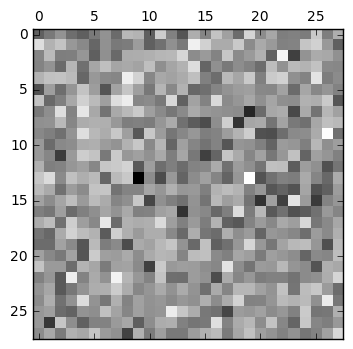

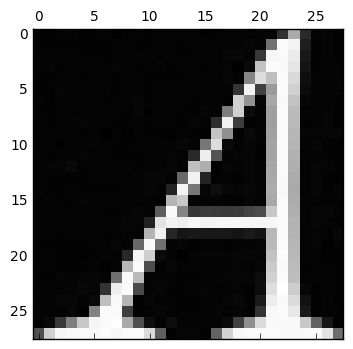

In [13]:
'''
Example of how terribly overfitted the model is at this point


'''

test_pred = sess.run(pred, feed_dict = {small_train: downscaled_test})
train_pred = sess.run(pred, feed_dict = {small_train: downscaled_train})
show_image(test_pred[0])
show_image(train_pred[0])

In [66]:
'''
Model 2

Uses single layer NN. No convolution. 
'''


small_train = tf.placeholder('float32', shape = [None, 14, 14])
large_train = tf.placeholder('float32', shape = [None, 28, 28])

small_train_flattened = tf.reshape(small_train,[-1,14*14])
large_train_flattened = tf.reshape(large_train,[-1,28*28])

#Decision layer
w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
b = tf.Variable(tf.truncated_normal([1,28*28]))
matrix_output = tf.matmul(small_train_flattened,w)+b

#Input Pass-through
reshaped_to_image_format = tf.reshape(small_train,[-1,14,14,1])
resized = tf.image.resize_images(reshaped_to_image_format,[28,28])
reshaped = tf.reshape(resized,[-1,28*28])

#Combination
multiplied = tf.mul(tf.add(matrix_output, reshaped), 0.5)

#Loss / prediction / optimization etc. 
MSE = tf.reduce_mean(tf.square(multiplied - large_train_flattened))
pred = tf.reshape(multiplied,[-1,28,28])
optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [67]:
#multiplied = tf.matmul(small_train_flattened,w)+b + tf.image.resize_bilinear

In [68]:
#multiplied = tf.matmul(small_train_flattened,w)+b + tf.image.resize_images

In [69]:
sess = tf.Session()
sess.run(init)

In [74]:
MAXSTEPS = 10000
for step in range(MAXSTEPS):
    (_,mse) = sess.run([optimizer,MSE],feed_dict = {small_train: downscaled_train, large_train: train_images})
    if (step % 1000)==0:
        test_mse = sess.run(MSE, feed_dict = {small_train: downscaled_test, large_train: test_images})
        print('step = %-5d MSE = %-10f Test MSE = %-10f' % (step,mse,test_mse))
print("Done!")

step = 0     MSE = 7.184829   Test MSE = 7.062532  
step = 1000  MSE = 0.402650   Test MSE = 1.238132  
step = 2000  MSE = 0.113105   Test MSE = 0.895335  
step = 3000  MSE = 0.042601   Test MSE = 0.764839  
step = 4000  MSE = 0.017623   Test MSE = 0.698966  
step = 5000  MSE = 0.007362   Test MSE = 0.662997  
step = 6000  MSE = 0.002964   Test MSE = 0.644197  
step = 7000  MSE = 0.001105   Test MSE = 0.636270  
step = 8000  MSE = 0.000375   Test MSE = 0.634812  
step = 9000  MSE = 0.000123   Test MSE = 0.636091  
Done!


In [73]:
sess.run(reshaped,feed_dict = {small_train: downscaled_train, large_train: train_images}).shape

(100, 784)

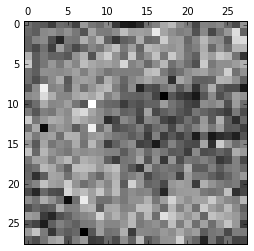

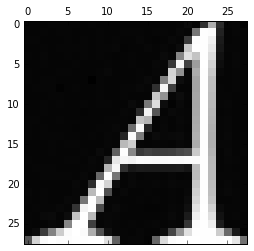

In [79]:
test_pred = sess.run(pred, feed_dict = {small_train: downscaled_test})
train_pred = sess.run(pred, feed_dict = {small_train: downscaled_train})
show_image(test_pred[0])
show_image(train_pred[0])

In [100]:
'''
Model 3

Uses convolution
'''
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

small_train = tf.placeholder('float32', shape = [None, 14, 14])
large_train = tf.placeholder('float32', shape = [None, 28, 28])

small_train_flattened = tf.reshape(small_train,[-1,14*14])
large_train_flattened = tf.reshape(large_train,[-1,28*28])

reshaped_to_image_format = tf.reshape(small_train,[-1,14,14,1])


w_conv1 = weight_variable([4,4,1,16])
b_conv1 = bias_variable([16])
h_conv1 = conv2d(reshaped_to_image_format, w_conv1) + b_conv1



#Decision layer
w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
b = tf.Variable(tf.truncated_normal([1,28*28]))
prediction = tf.matmul(small_train_flattened,w)+b


#Loss / prediction / optimization etc. 
MSE = tf.reduce_mean(tf.square(prediction - large_train_flattened))
pred = tf.reshape(multiplied,[-1,28,28])
optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [101]:
sess = tf.Session()
sess.run(init)

In [90]:
MAXSTEPS = 1000
for step in range(MAXSTEPS):
    (_,mse) = sess.run([optimizer,MSE],feed_dict = {small_train: downscaled_train, large_train: train_images})
    if (step % 1000)==0:
        test_mse = sess.run(MSE, feed_dict = {small_train: downscaled_test, large_train: test_images})
        print('step = %-5d MSE = %-10f Test MSE = %-10f' % (step,mse,test_mse))
print("Done!")

step = 0     MSE = 0.406340   Test MSE = 1.232344  
Done!


In [102]:
sess.run(h_conv1,feed_dict = {small_train: downscaled_train, large_train: train_images}).shape

(100, 7, 7, 16)

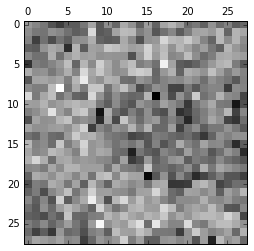

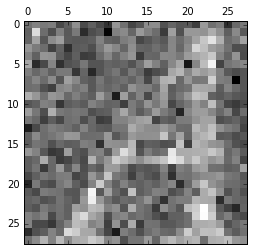

In [92]:
test_pred = sess.run(pred, feed_dict = {small_train: downscaled_test})
train_pred = sess.run(pred, feed_dict = {small_train: downscaled_train})
show_image(test_pred[0])
show_image(train_pred[0])